<a href="https://colab.research.google.com/github/repoocsov/Build_Week_2/blob/master/build_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing/Cleaning/Feature Creation

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# The Average block size in MB
df2 = pd.read_csv('BCHAIN-AVBLS.csv')
df2 = df2.rename(columns={'Value': 'block size (mb)'})

# Data showing miners revenue divided by the number of transactions.
df3 = pd.read_csv('BCHAIN-CPTRA.csv')
df3 = df3.rename(columns={'Value': 'miner rev per transaction'})

# Difficulty is a measure of how difficult it is to find a hash below a given target.
df4 = pd.read_csv('BCHAIN-DIFF.csv')
df4 = df4.rename(columns={'Value': 'difficulty'})

# The estimated number of giga hashes per second (billions of hashes per second) the bitcoin network is performing.
df5 = pd.read_csv('BCHAIN-HRATE.csv')
df5 = df5.rename(columns={'Value': 'giga hashes per second'})

# Historical data showing (number of bitcoins mined per day + transaction fees) * market price.
df6 = pd.read_csv('BCHAIN-MIREV.csv')
df6 = df6.rename(columns={'Value': 'miner rev'})

# Bitcoin Market Price USD
df7 = pd.read_csv('BCHAIN-MKPRU.csv')
df7 = df7.rename(columns={'Value': 'price'})

# Number of unique bitcoin addresses used per day.
df8 = pd.read_csv('BCHAIN-NADDU.csv')
df8 = df8.rename(columns={'Value': 'unique addresses'})

# Total number of unique bitcoin transactions per day.
df9 = pd.read_csv('BCHAIN-NTRAN.csv')
df9 = df9.rename(columns={'Value': 'unique transactions'})

# The average number of transactions per block.
df10 = pd.read_csv('BCHAIN-NTRBL.csv')
df10 = df10.rename(columns={'Value': 'transactions per block'})

# Data showing the total number of unique bitcoin transactions per day excluding those which involve any of the top 100 most popular addresses popular addresses.
df11 = pd.read_csv('BCHAIN-NTREP.csv')
df11 = df11.rename(columns={'Value': 'total transactions minus most popular'})

# Data showing the total BTC value of transaction fees miners earn per day.
df12 = pd.read_csv('BCHAIN-TRFEE.csv')
df12 = df12.rename(columns={'Value': 'fee rev (btc)'})

# Data showing the total BTC value of transaction fees miners earn per day in USD.
df13 = pd.read_csv('BCHAIN-TRFUS.csv')
df13 = df13.rename(columns={'Value': 'fee rev (usd)'})

# Bitcoin USD Exchange Trade Volume
df14 = pd.read_csv('BCHAIN-TRVOU.csv')
df14 = df14.rename(columns={'Value': 'exchange volume (usd)'})

In [0]:
# Merging the dataframes
from functools import reduce
dataframes = [ df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14]

df = reduce(lambda df1,df2: pd.merge(df1,df2,on='Date'), dataframes)

In [41]:
df.head(3)

,Date,block size (mb),miner rev per transaction,difficulty,giga hashes per second,miner rev,price,unique addresses,unique transactions,transactions per block,total transactions minus most popular,fee rev (btc),fee rev (usd),exchange volume (usd)
0,2020-03-01,0.989318,49.679886,1.548691e+13,1.070104e+08,1.527791e+07,8712.35,440839.0,307527.0,2212.424460,302722.0,18.503956,160837.600124,1.238408e+08
1,2020-02-29,1.082665,47.239700,1.548691e+13,1.216377e+08,1.741208e+07,8804.72,516812.0,368590.0,2332.848101,363076.0,26.282587,228249.806726,1.479771e+08
2,2020-02-28,1.102626,48.413917,1.548691e+13,1.131692e+08,1.640172e+07,8785.52,495750.0,338781.0,2304.632653,333621.0,26.959644,237352.834056,2.069299e+08


In [0]:
import numpy as np

# fee rev (usd) / unique transactions = average transaction fee
df['average transaction fee (usd)'] = df['fee rev (usd)'] / df['unique transactions']
df['average transaction fee (usd)'] = df['average transaction fee (usd)'].replace({np.nan: 0})

In [43]:
df['average transaction fee (usd)'].describe()

count    4074.000000
mean        0.859619
std         3.564486
min         0.000000
25%         0.003728
50%         0.071538
75%         0.402241
max        59.700407
Name: average transaction fee (usd), dtype: float64

In [0]:
# Creating a usable date column
df['Date'] = pd.to_datetime(df['Date'])
df['days_since_genesis'] = [(date - pd.to_datetime('2009-01-04')).days for date in df['Date']]

In [0]:
subset = ['Date', 'days_since_genesis', 'block size (mb)', 'difficulty', 'giga hashes per second', 'price', 'unique addresses', 'unique transactions', 'transactions per block',
            'total transactions minus most popular', 'exchange volume (usd)', 'average transaction fee (usd)']

df = df[subset]

In [0]:
# Differences from day prior
df['hash_change_day_prior'] = (df['giga hashes per second'].diff().abs()).shift(-1)
df['block_size_day_prior'] = (df['block size (mb)'].diff().abs()).shift(-1)
df['exchange_volume_change_day_prior'] = (df['exchange volume (usd)'].diff().abs()).shift(-1)
df['price_change_day_prior'] = (df['price'].diff().abs()).shift(-1)
df['unique_transactions_day_prior'] = (df['unique transactions'].diff().abs()).shift(-1)
df['unique_addresses_day_prior'] = (df['unique addresses'].diff().abs()).shift(-1)

# Assuming a 3500 transaction per block limit
df['transactions_per_block_percentage'] = df['transactions per block'] /3500

# Dropping columns
df = df.drop(columns=['block size (mb)','difficulty','giga hashes per second','unique addresses','unique transactions',
                      'transactions per block','total transactions minus most popular','exchange volume (usd)'])

In [0]:
# # Getting rid of the dates when a Bitcoin fee market didn't exist
# df = df[df['average transaction fee (usd)'] > 0]

In [48]:
df['average transaction fee (usd)']

0       0.523003
1       0.619251
2       0.700608
3       0.802527
4       0.721758
          ...   
4069    0.000000
4070    0.000000
4071    0.000000
4072    0.000000
4073    0.000000
Name: average transaction fee (usd), Length: 4074, dtype: float64

In [0]:
"""
  Binning average 'transaction fee (usd)'.
  This makes it a classification problem.
    - Negligible (0-10 cents)
    - Cheap (10-50 cents)
    - Medium (50-200 cents)
    - Costly (200+ cents)
"""
df['fee'] = ['place_holder'] * len(df['average transaction fee (usd)'])
series = []

for index, item in df.iterrows():
  if(item['average transaction fee (usd)'] <= .1):
    item['fee'] = 'Negligible (0-10 cents)'
  elif(item['average transaction fee (usd)'] <= .5):
    item['fee'] = 'Cheap (10-50 cents)'
  elif(item['average transaction fee (usd)'] <= 2):
    item['fee'] = 'Medium (50-200 cents)'
  else:
    item['fee'] = 'Costly (200+ cents)'

  series.append(item['fee'])
  


df['fee'] = series

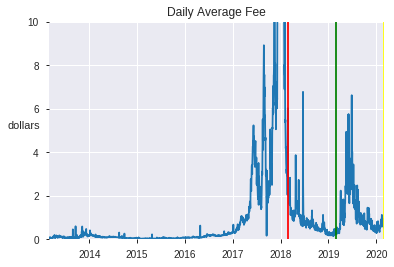

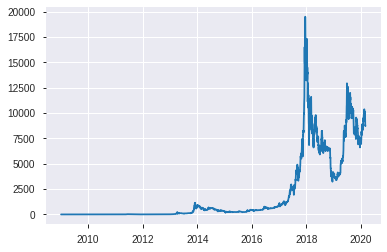

In [50]:
import matplotlib.pyplot as plt

plt.plot(df['Date'], df['average transaction fee (usd)'])
plt.ylim(0,10)
plt.xlim('2013-03-01','2020-03-01')
plt.title('Daily Average Fee')
plt.ylabel('dollars', rotation=0)
plt.axvline(x='2018-03-01', c='red')
plt.axvline(x='2019-03-01', c='green')
plt.axvline(x='2020-03-01', c='yellow')
plt.show()
plt.plot(df['Date'], df['price'])

In [51]:
import numpy as np
np.corrcoef(df['price'], df['average transaction fee (usd)'])

array([[1.        , 0.56300802],
       [0.56300802, 1.        ]])

In [52]:
df['fee'].value_counts()

Negligible (0-10 cents)    2366
Cheap (10-50 cents)         785
Medium (50-200 cents)       576
Costly (200+ cents)         347
Name: fee, dtype: int64

In [53]:
from pandas_profiling import ProfileReport

ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,12
Number of observations,4074
Total Missing (%),0.0%
Total size in memory,413.8 KiB
Average record size in memory,104.0 B
Numeric,9
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,1


# Train/Test Split

In [0]:
# The fee market didn't develop until later. This is an arbitrary start date, but it's close to when fees became more prevelant
train_start = '2011-01-11'
train_end = '2018-03-01'

val_start = '2018-03-01'
val_end = '2019-03-01'

test_start = '2019-03-01'
test_end = '2020-03-01'

# Train
conditional = ((df['Date'] >= train_start) & (df['Date'] < train_end))
train = df[conditional]

# Val
conditional = ((df['Date'] >= val_start) & (df['Date'] < val_end))
val = df[conditional]

# Train+Val
conditional = ((df['Date'] >= train_start) & (df['Date'] < val_end))
trainval = df[conditional]

# Test
conditional = ((df['Date'] >= test_start) & (df['Date'] <= test_end))
test = df[conditional]

In [0]:
features = ['days_since_genesis', 'hash_change_day_prior', 'unique_transactions_day_prior', 'block_size_day_prior',
            'unique_addresses_day_prior', 'transactions_per_block_percentage']
target = 'fee'


X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_final = trainval[features]
y_final = trainval[target]

X_test = test[features]
y_test = test[target]

In [56]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2606, 6), (2606,), (365, 6), (365,), (366, 6), (366,))

# Modeling

###Baseline

In [57]:
baseline = val['fee'].value_counts(normalize=True).max()
print(baseline, 'assuming all negligible.')

0.5753424657534246 assuming all negligible.


###Linear Model (Logtistic Regression)

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_model = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='median'),
    StandardScaler(),
    LogisticRegression(solver='lbfgs')
)

logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_val)
accuracy_score(y_val, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.052054794520547946

###Tree Based Model

In [59]:
model = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators = 1000, random_state = 42)
        )

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=Fa

In [60]:
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

0.052054794520547946

In [61]:
# Tree model on train/val combined
model = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators = 1000, random_state = 42)
        )

model.fit(X_final, y_final)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.16939890710382513

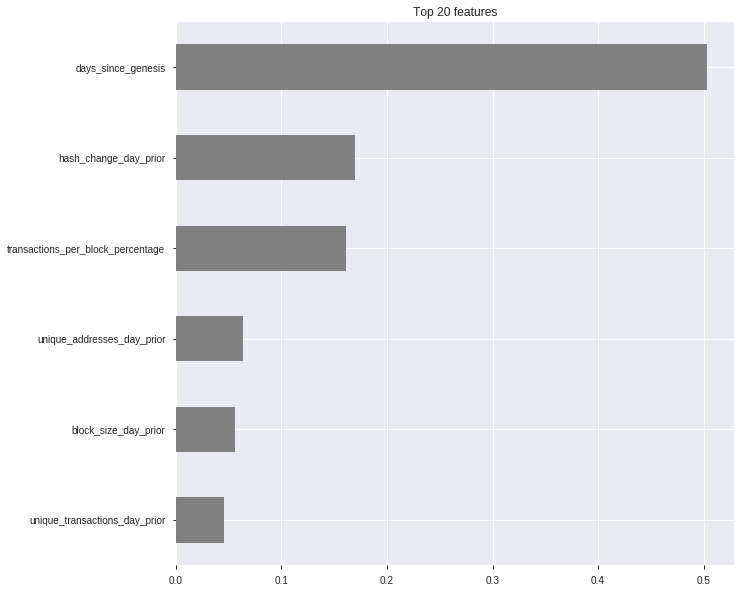

In [62]:
# Get feature importances
rf = model.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [63]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('standardscaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(bootstrap=True,
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                        max_depth=None,
                                                                        max_features='aut

In [64]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

unique_transactions_day_prior        0.018630
unique_addresses_day_prior           0.026849
block_size_day_prior                 0.028493
hash_change_day_prior                0.036712
transactions_per_block_percentage    0.066301
days_since_genesis                   0.436164
dtype: float64

In [65]:
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.4362 ± 0.0450,days_since_genesis
0.0663 ± 0.0191,transactions_per_block_percentage
0.0367 ± 0.0141,hash_change_day_prior
0.0285 ± 0.0056,block_size_day_prior
0.0268 ± 0.0122,unique_addresses_day_prior
0.0186 ± 0.0122,unique_transactions_day_prior


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

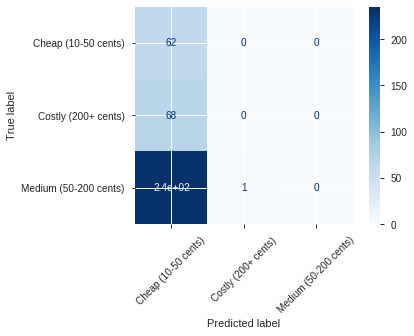

In [66]:
""" CONFUSION MATRIX """
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues)

plt.xticks(rotation=45)

In [67]:
""" K NEIGHBORS """
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_val)
accuracy_score(y_val, y_pred)

0.08767123287671233

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

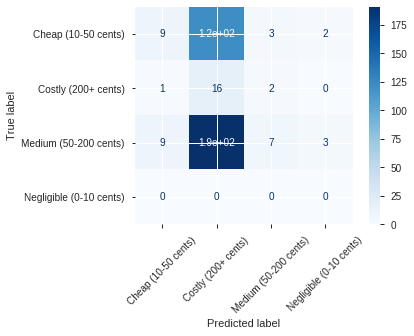

In [68]:
disp = plot_confusion_matrix(neigh, X_val, y_val,
                                 cmap=plt.cm.Blues)

plt.xticks(rotation=45)

#Exploration

In [69]:
X_train.head(5)

,days_since_genesis,hash_change_day_prior,unique_transactions_day_prior,block_size_day_prior,unique_addresses_day_prior,transactions_per_block_percentage
731,3342,2.840459e+06,33150.0,0.033878,58798.0,0.392186
732,3341,4.484936e+06,41605.0,0.272153,80184.0,0.377860
733,3340,3.886944e+06,9665.0,0.317733,584.0,0.242053
734,3339,4.484936e+05,30659.0,0.021601,69281.0,0.304500
735,3338,1.494979e+05,1958.0,0.087337,75031.0,0.357515


In [70]:
y_train

731         Costly (200+ cents)
732         Costly (200+ cents)
733         Costly (200+ cents)
734         Costly (200+ cents)
735         Costly (200+ cents)
                 ...           
3332    Negligible (0-10 cents)
3333    Negligible (0-10 cents)
3334    Negligible (0-10 cents)
3335    Negligible (0-10 cents)
3336    Negligible (0-10 cents)
Name: fee, Length: 2606, dtype: object

In [71]:
import seaborn as sns

sns.pairplot(df)

In [72]:
df.corr()

,days_since_genesis,price,average transaction fee (usd),hash_change_day_prior,block_size_day_prior,exchange_volume_change_day_prior,price_change_day_prior,unique_transactions_day_prior,unique_addresses_day_prior,transactions_per_block_percentage
days_since_genesis,1.000000,0.720160,0.258043,0.519837,0.561869,0.309322,0.392273,0.584890,0.601527,0.923331
price,0.720160,1.000000,0.563008,0.599725,0.413521,0.506847,0.649641,0.453493,0.515694,0.706423
average transaction fee (usd),0.258043,0.563008,1.000000,0.077069,-0.001027,0.594820,0.555131,0.286251,0.303438,0.320789
hash_change_day_prior,0.519837,0.599725,0.077069,1.000000,0.436506,0.161411,0.285685,0.352582,0.322531,0.506516
block_size_day_prior,0.561869,0.413521,-0.001027,0.436506,1.000000,0.095628,0.142640,0.395274,0.443484,0.473559
exchange_volume_change_day_prior,0.309322,0.506847,0.594820,0.161411,0.095628,1.000000,0.528190,0.301157,0.321561,0.333353
price_change_day_prior,0.392273,0.649641,0.555131,0.285685,0.142640,0.528190,1.000000,0.286964,0.325617,0.407626
unique_transactions_day_prior,0.584890,0.453493,0.286251,0.352582,0.395274,0.301157,0.286964,1.000000,0.775034,0.618030
unique_addresses_day_prior,0.601527,0.515694,0.303438,0.322531,0.443484,0.321561,0.325617,0.775034,1.000000,0.592854
transactions_per_block_percentage,0.923331,0.706423,0.320789,0.506516,0.473559,0.333353,0.407626,0.618030,0.592854,1.000000
